In [42]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet152
import matplotlib.pyplot as plt


# Tensorflow load dataset

In [1]:
folder_path = '/home/daniel/code/dosorio79/code/kolapally/computer_vision/raw_data/cropped_clean'

In [35]:
train, test_set = tf.keras.utils.image_dataset_from_directory(folder_path,
                                                         labels='inferred',
                                                         label_mode='categorical',
                                                         image_size=(128,128),
                                                         validation_split = 0.2,
                                                         batch_size=32,
                                                         seed = 0,
                                                         subset = 'both',
                                                         interpolation = 'bicubic',
                                                         crop_to_aspect_ratio = True)

Found 1091 files belonging to 6 classes.
Using 873 files for training.
Using 218 files for validation.


In [36]:
train_split = 0.2
train_batches = int((1-train_split)*train.cardinality().numpy())
class_names = train.class_names

train_set = train.take(train_batches)
val_set = train.skip(train_batches)

# images output

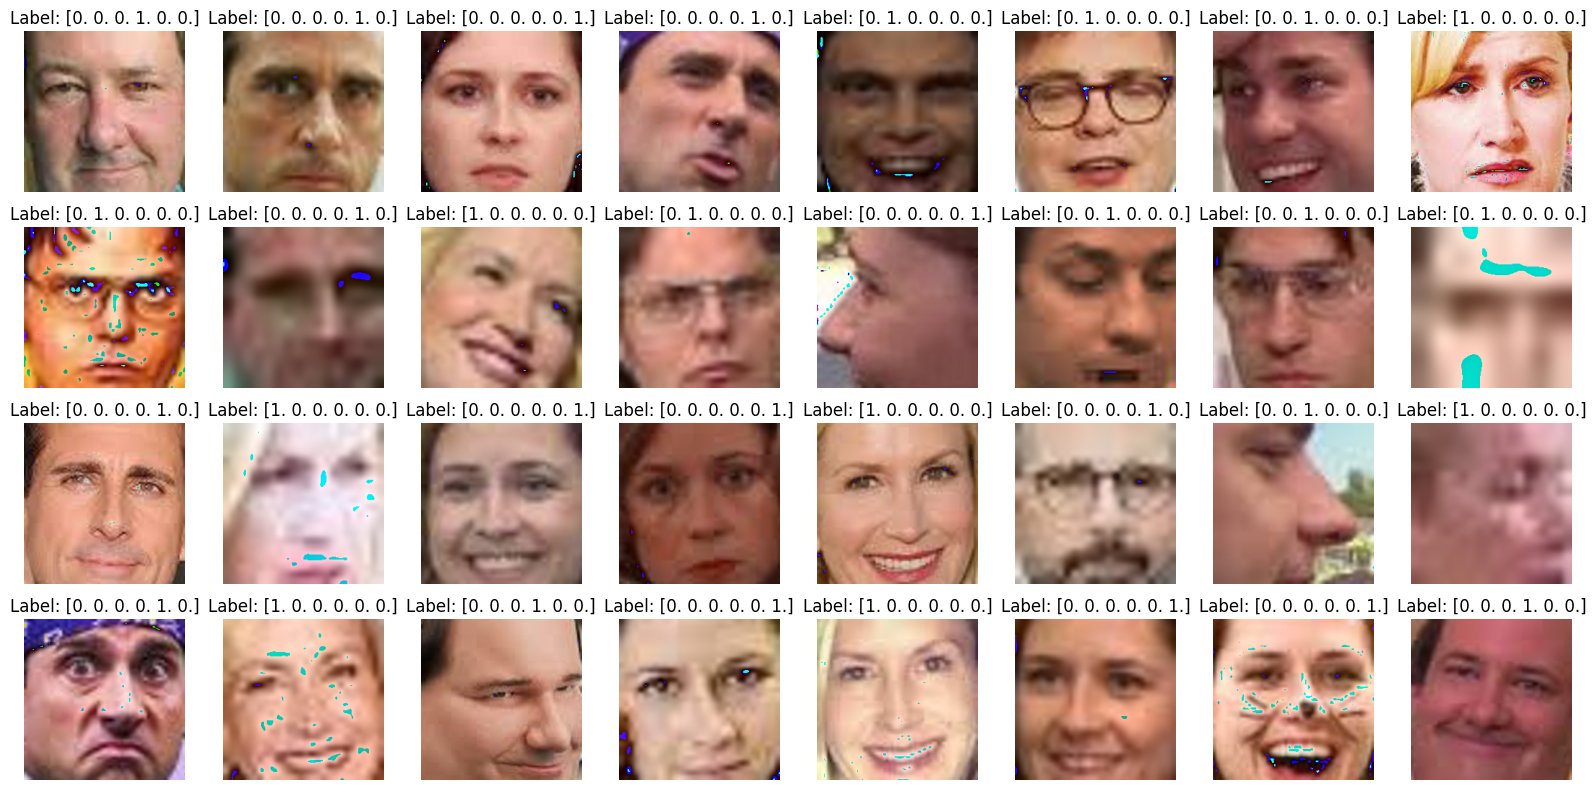

In [11]:
# Get one batch of images and labels
for images, labels in train_set.take(1):
    # Plot the images
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis('off')
        ax.set_title(f'Label: {labels[i]}')
    plt.tight_layout()
    plt.show()

# Inception V3

In [38]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained InceptionV1 model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_15 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 6)                 774       
                                                                 
Total params: 23,933,862
Trainable params: 2,131,078
N

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
             )

In [29]:
es = tf.keras.callbacks.EarlySDSOtopping(monitor='val_accuracy', patience = 20, restore_best_weights=True)

In [41]:
history = model.fit(train_set,
                  epochs = 500,
                  batch_size=32,
                  verbose=1,
                  validation_data=val_set,
                  callbacks = [es]
              )

Epoch 1/500
22/22 [==============================] - 17s 530ms/step - loss: 178.7529 - accuracy: 0.2074 - val_loss: 65.8595 - val_accuracy: 0.3136
Epoch 2/500
22/22 [==============================] - 10s 458ms/step - loss: 22.5447 - accuracy: 0.2145 - val_loss: 1.8803 - val_accuracy: 0.1657
Epoch 3/500
22/22 [==============================] - 11s 498ms/step - loss: 2.7408 - accuracy: 0.1932 - val_loss: 1.7692 - val_accuracy: 0.1775
Epoch 4/500
22/22 [==============================] - 11s 485ms/step - loss: 1.7870 - accuracy: 0.1974 - val_loss: 1.7726 - val_accuracy: 0.2130
Epoch 5/500
22/22 [==============================] - 10s 477ms/step - loss: 1.7796 - accuracy: 0.1903 - val_loss: 1.7640 - val_accuracy: 0.1598
Epoch 6/500
22/22 [==============================] - 10s 478ms/step - loss: 1.7847 - accuracy: 0.1989 - val_loss: 1.7724 - val_accuracy: 0.1598
Epoch 7/500
22/22 [==============================] - 10s 448ms/step - loss: 1.7768 - accuracy: 0.1960 - val_loss: 1.7764 - val_accur

In [ ]:
# %tensorboard --logdir logs/fit

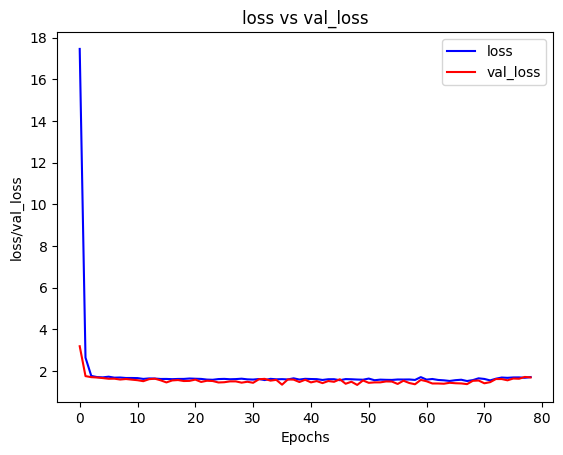

In [31]:
plt.plot(model.history.history['loss'],color='b',label='loss')
plt.plot(model.history.history['val_loss'],color='r',label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss/val_loss')
plt.title('loss vs val_loss')
plt.show()

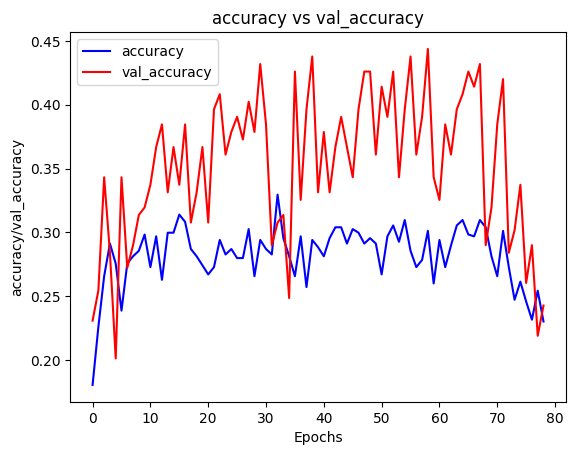

In [32]:
plt.plot(model.history.history['accuracy'],color='b',label = 'accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label = 'val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy/val_accuracy')
plt.title('accuracy vs val_accuracy')
plt.show()

In [34]:
model.evaluate(test_set
              )

7/7 [==============================] - 10s 1s/step - loss: 1.6036 - accuracy: 0.3349


[1.6036392450332642, 0.3348623812198639]

# ResNet152 with augmentation

In [46]:
base_model = ResNet152(include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with augmentation
model = tf.keras.Sequential([ 
                             tf.keras.layers.RandomFlip('horizontal', input_shape=(128, 128, 3)),
                             tf.keras.layers.RandomRotation(0.2),
                             base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')
                             ])

In [47]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy']
             )

In [50]:
history = model.fit(train_set,
                  epochs = 100,
                  batch_size=32,
                  verbose=1,
                  validation_data=val_set,
                  callbacks = [es]
              )

Epoch 1/100
22/22 [==============================] - 77s 3s/step - loss: 8.7149 - accuracy: 0.2102 - val_loss: 1.7573 - val_accuracy: 0.4083
Epoch 2/100
22/22 [==============================] - 61s 3s/step - loss: 2.0019 - accuracy: 0.2784 - val_loss: 1.5033 - val_accuracy: 0.3964
Epoch 3/100
22/22 [==============================] - 63s 3s/step - loss: 1.7007 - accuracy: 0.3026 - val_loss: 1.4246 - val_accuracy: 0.4970
Epoch 4/100
22/22 [==============================] - 67s 3s/step - loss: 1.5788 - accuracy: 0.3892 - val_loss: 1.3657 - val_accuracy: 0.4615
Epoch 5/100
22/22 [==============================] - 66s 3s/step - loss: 1.4955 - accuracy: 0.3707 - val_loss: 1.2617 - val_accuracy: 0.5089
Epoch 6/100
22/22 [==============================] - 67s 3s/step - loss: 1.5317 - accuracy: 0.3793 - val_loss: 1.2498 - val_accuracy: 0.5266
Epoch 7/100
22/22 [==============================] - 71s 3s/step - loss: 1.5146 - accuracy: 0.3906 - val_loss: 1.2836 - val_accuracy: 0.5207
Epoch 8/100
2

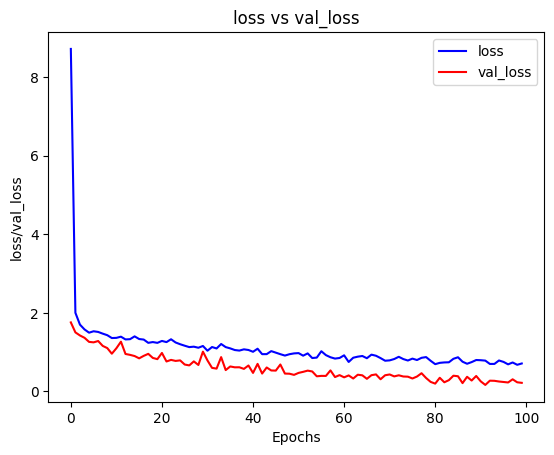

In [51]:


plt.plot(model.history.history['loss'],color='b',label='loss')
plt.plot(model.history.history['val_loss'],color='r',label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss/val_loss')
plt.title('loss vs val_loss')
plt.show()

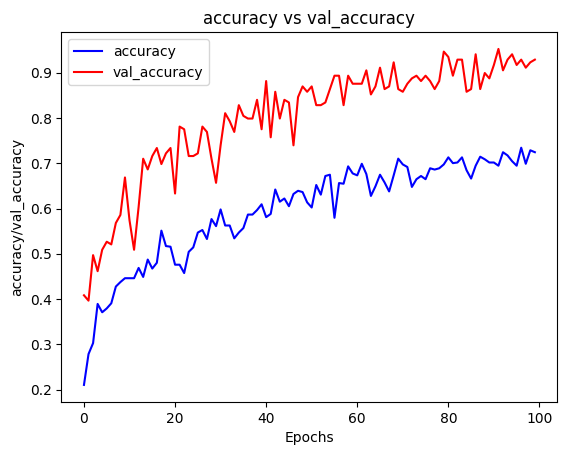

In [53]:
plt.plot(model.history.history['accuracy'],color='b',label = 'accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label = 'val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy/val_accuracy')
plt.title('accuracy vs val_accuracy')
plt.show()

In [54]:
model.evaluate(test_set)

7/7 [==============================] - 15s 2s/step - loss: 0.7032 - accuracy: 0.7752


[0.703208863735199, 0.7752293348312378]

# Resnet 152 with augmentation custom learning rate

In [74]:
base_model = ResNet152(include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with augmentation
model = tf.keras.Sequential([ 
                             tf.keras.layers.RandomFlip('horizontal', input_shape=(128, 128, 3)),
                             tf.keras.layers.RandomRotation(0.2),
                             base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')
                             ])

In [75]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_7 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_39 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                     

In [76]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [77]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 20, restore_best_weights=True)

In [78]:
history = model.fit(train_set,
                  epochs = 500,
                  batch_size=32,
                  verbose=1,
                  validation_data=val_set,
                  callbacks = [es]
              )

Epoch 1/500
22/22 [==============================] - 85s 3s/step - loss: 21.2793 - accuracy: 0.2230 - val_loss: 4.1738 - val_accuracy: 0.2899
Epoch 2/500
22/22 [==============================] - 61s 3s/step - loss: 3.9429 - accuracy: 0.2472 - val_loss: 1.8249 - val_accuracy: 0.2426
Epoch 3/500
22/22 [==============================] - 60s 3s/step - loss: 1.8946 - accuracy: 0.2315 - val_loss: 1.6147 - val_accuracy: 0.3314
Epoch 4/500
22/22 [==============================] - 60s 3s/step - loss: 1.7340 - accuracy: 0.2756 - val_loss: 1.6365 - val_accuracy: 0.3728
Epoch 5/500
22/22 [==============================] - 57s 3s/step - loss: 1.7694 - accuracy: 0.2713 - val_loss: 1.6116 - val_accuracy: 0.4201
Epoch 6/500
22/22 [==============================] - 60s 3s/step - loss: 1.6514 - accuracy: 0.3153 - val_loss: 1.5136 - val_accuracy: 0.4497
Epoch 7/500
22/22 [==============================] - 61s 3s/step - loss: 1.6692 - accuracy: 0.3139 - val_loss: 1.6961 - val_accuracy: 0.3491
Epoch 8/500


In [64]:
# Helper function to plot loss and accuracy curves
def plot_curves(loss_curve, val_loss_curve, accuracy_curve, val_accuracy_curve):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(loss_curve, color='b', label='loss')
    ax1.plot(val_loss_curve, color='r', label='val_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Val_loss')
    
    ax2.plot(accuracy_curve, color='b', label='accuracy')
    ax2.plot(val_accuracy_curve, color='r', label='val_accuracy')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Val_accuracy')
    
    plt.show()

In [ ]:
plot_curves(model.history.history['loss'], model.history.history['val_loss'], model.history.history['accuracy'], model.history.history['val_accuracy'])

In [79]:
model.evaluate(test_set)

7/7 [==============================] - 15s 2s/step - loss: 1.0536 - accuracy: 0.6651


[1.0536223649978638, 0.6651375889778137]

# Resnet 152 with augmentation custom learning rate, no dropouts

In [80]:
base_model = ResNet152(include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with augmentation
model = tf.keras.Sequential([ 
                             tf.keras.layers.RandomFlip('horizontal', input_shape=(128, 128, 3)),
                             tf.keras.layers.RandomRotation(0.2),
                             base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation='relu'),
                             #tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(6, activation='softmax')
                             ])

In [81]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_11 (Flatten)        (None, 32768)             0         
                                                                 
 dense_42 (Dense)            (None, 256)               8388864   
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                     

In [82]:
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [83]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 20, restore_best_weights=True)

In [84]:
history = model.fit(train_set,
                  epochs = 500,
                  batch_size=32,
                  verbose=1,
                  validation_data=val_set,
                  callbacks = [es]
              )

Epoch 1/500
22/22 [==============================] - 77s 3s/step - loss: 14.2313 - accuracy: 0.2812 - val_loss: 3.0861 - val_accuracy: 0.4201
Epoch 2/500
22/22 [==============================] - 51s 2s/step - loss: 2.3115 - accuracy: 0.5199 - val_loss: 1.4546 - val_accuracy: 0.5917
Epoch 3/500
22/22 [==============================] - 46s 2s/step - loss: 2.0891 - accuracy: 0.5327 - val_loss: 0.9935 - val_accuracy: 0.7515
Epoch 4/500
22/22 [==============================] - 46s 2s/step - loss: 1.2866 - accuracy: 0.6790 - val_loss: 1.0274 - val_accuracy: 0.7396
Epoch 5/500
22/22 [==============================] - 46s 2s/step - loss: 0.9153 - accuracy: 0.7386 - val_loss: 0.8746 - val_accuracy: 0.7692
Epoch 6/500
22/22 [==============================] - 47s 2s/step - loss: 0.9239 - accuracy: 0.7216 - val_loss: 0.4609 - val_accuracy: 0.8580
Epoch 7/500
22/22 [==============================] - 45s 2s/step - loss: 0.7090 - accuracy: 0.7827 - val_loss: 0.6429 - val_accuracy: 0.8343
Epoch 8/500


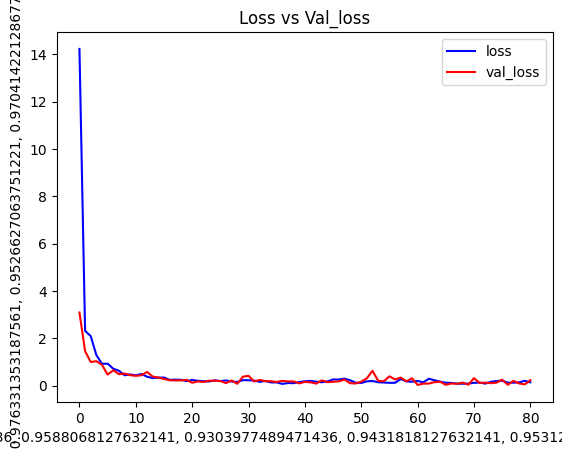

In [85]:
plot_curves(model.history.history['loss'], model.history.history['val_loss'], model.history.history['accuracy'], model.history.history['val_accuracy'])

In [86]:
model.evaluate(test_set)

7/7 [==============================] - 14s 2s/step - loss: 1.2075 - accuracy: 0.7890


[1.2075275182724, 0.78899085521698]